In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

print('Libraries imported.')

Libraries imported.


In [ ]:
# Training constants
BATCH_SIZE = 128
N_EPOCH = 20
N_CLASSES = 100
VERBOSE = 1
VALIDATION_SPLIT = 0.2

print('Main variables initialised.')

Main variables initialised.


In [ ]:
# STL-10 is a set of 13k images 96x96 pixels on 3 channels
IMG_CHANNELS = 3
IMG_ROWS = 32
IMG_COLS = 32

print('Image variables initialisation')

Image variables initialisation


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
print('Dataset loaded.')

100%|██████████| 169M/169M [00:04<00:00, 39.8MB/s]


Dataset loaded.


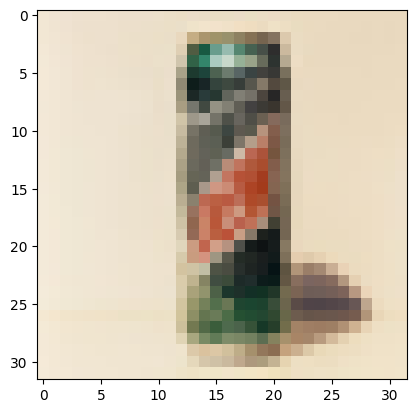

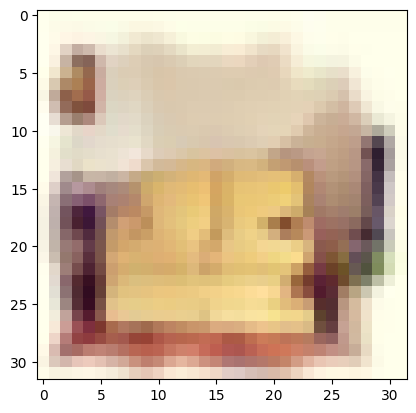

In [ ]:
# Visualizing sample images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(images[2])
imshow(images[3])

In [ ]:
# Define a deeper model
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, N_CLASSES)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

print('Deep CNN network defined.')

# N_EPOCH = 40  # Extended training epochs

Deep CNN network defined.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepCNN().to(device)

# Define validation split
dataset_size = len(trainset)
val_size = int(VALIDATION_SPLIT * dataset_size)
train_size = dataset_size - val_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training function
def train_model():
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(N_EPOCH):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss, val_correct, val_total = 0.0, 0, 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        history['loss'].append(running_loss / len(trainloader))
        history['val_loss'].append(val_loss / len(valloader))
        scheduler.step(history['val_loss'][-1])
        history['accuracy'].append(correct / total)
        history['val_accuracy'].append(val_correct / val_total)
        print(f"Epoch {epoch+1}/{N_EPOCH}, Loss: {history['loss'][-1]:.4f}, Accuracy: {history['accuracy'][-1]:.4f}, Val Loss: {history['val_loss'][-1]:.4f}, Val Accuracy: {history['val_accuracy'][-1]:.4f}")


    print('Training complete.')
    return history

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
history = train_model()

Epoch 1/20, Loss: 4.2843, Accuracy: 0.0454, Val Loss: 3.9538, Val Accuracy: 0.1000
Epoch 2/20, Loss: 3.8859, Accuracy: 0.0949, Val Loss: 3.6573, Val Accuracy: 0.1435
Epoch 3/20, Loss: 3.6843, Accuracy: 0.1267, Val Loss: 3.4195, Val Accuracy: 0.1800
Epoch 4/20, Loss: 3.5563, Accuracy: 0.1457, Val Loss: 3.2815, Val Accuracy: 0.2140
Epoch 5/20, Loss: 3.4403, Accuracy: 0.1694, Val Loss: 3.1849, Val Accuracy: 0.2292
Epoch 6/20, Loss: 3.3581, Accuracy: 0.1828, Val Loss: 3.0790, Val Accuracy: 0.2571
Epoch 7/20, Loss: 3.2804, Accuracy: 0.1979, Val Loss: 2.9857, Val Accuracy: 0.2691
Epoch 8/20, Loss: 3.2141, Accuracy: 0.2080, Val Loss: 2.9256, Val Accuracy: 0.2844
Epoch 9/20, Loss: 3.1599, Accuracy: 0.2186, Val Loss: 2.8678, Val Accuracy: 0.2940
Epoch 10/20, Loss: 3.1120, Accuracy: 0.2261, Val Loss: 2.8116, Val Accuracy: 0.2986
Epoch 11/20, Loss: 3.0553, Accuracy: 0.2366, Val Loss: 2.7688, Val Accuracy: 0.3224
Epoch 12/20, Loss: 3.0213, Accuracy: 0.2439, Val Loss: 2.7046, Val Accuracy: 0.3241
E

In [ ]:
# Save model state dictionary
torch.save(model.state_dict(), 'cnn3_6_model.pth')

# Save entire model
torch.save(model, 'cnn3_6_model_full.pth')

print('Model and weights saved successfully.')

Model and weights saved successfully.



Test loss: 0.6771
Test accuracy: 76.81%


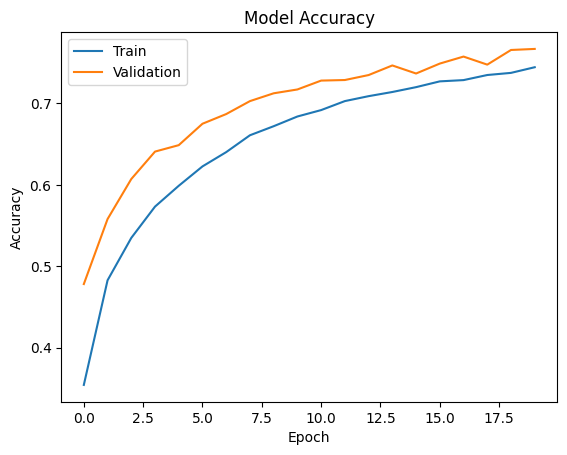

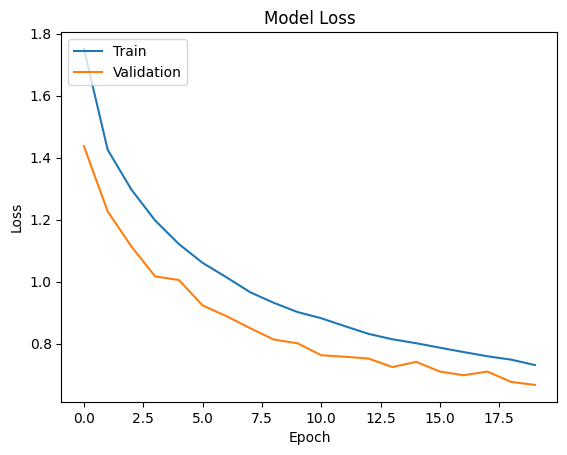

In [ ]:
# Testing the model
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(testloader)
test_accuracy = 100. * correct / total

print(f"\nTest loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.2f}%")

# Plot training history
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss history
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
